#### Introduction
In this project, we applied Propensity Score Matching (PSM) to reduce selection bias when estimating the effect of a treatment using observational data. We conducted t-tests to analyze baseline differences and built a logistic regression model to estimate propensity scores. After matching, we recomputed propensity scores using the matched dataset and visualized the common support region to assess the overlap between treated and control groups.

In [ ]:
# Install.packages("MatchIt")
library(MatchIt)

# Load dataset
dataset <- read.csv("lalonde.csv")
head(dataset, n = 5)

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
1,1,37,11,1,0,1,1,0,0,9930.0460
2,1,22,9,0,1,0,1,0,0,3595.8940
3,1,30,12,1,0,0,0,0,0,24909.4500
4,1,27,11,1,0,0,1,0,0,7506.1460
5,1,33,8,1,0,0,1,0,0,289.7899


In [ ]:
# Calculate the income average in 78
# Install.packages("dplyr")
library(dplyr)
dataset %>%
  group_by(treat) %>%
  summarise(mean_income_78 = mean(re78))

treat,mean_income_78
<int>,<dbl>
0,6984.170
1,6349.144


In [ ]:
# Calculate the averages of the confounders
confounders <- c("re74", "re75", "age", "educ", "black", "hispan", "married",
                 "nodegree")
dataset %>%
  group_by(treat) %>%
  select(one_of(confounders)) %>%
  summarise_all(list(~ mean(., na.rm = TRUE)))

Adding missing grouping variables: `treat`


treat,re74,re75,age,educ,black,hispan,married,nodegree
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,5619.237,2466.484,28.03030,10.23543,0.2027972,0.14219114,0.5128205,0.5967366
1,2095.574,1532.055,25.81622,10.34595,0.8432432,0.05945946,0.1891892,0.7081081


In [ ]:
# t test the continuous confounders
continuous_confounders <- c("re74", "re75", "age", "educ")
t.test(dataset$re74 ~ dataset$treat)
t.test(dataset[, 're74'] ~ dataset[, 'treat'])
lapply(continuous_confounders, function(variable){
  t.test(dataset[, variable] ~ dataset[, 'treat'])})


	Welch Two Sample t-test

data:  dataset$re74 by dataset$treat
t = 7.2456, df = 475.99, p-value = 1.748e-12
alternative hypothesis: true difference in means between group 0 and group 1 is not equal to 0
95 percent confidence interval:
 2568.067 4479.258
sample estimates:
mean in group 0 mean in group 1 
       5619.237        2095.574 



	Welch Two Sample t-test

data:  dataset[, "re74"] by dataset[, "treat"]
t = 7.2456, df = 475.99, p-value = 1.748e-12
alternative hypothesis: true difference in means between group 0 and group 1 is not equal to 0
95 percent confidence interval:
 2568.067 4479.258
sample estimates:
mean in group 0 mean in group 1 
       5619.237        2095.574 


[[1]]

	Welch Two Sample t-test

data:  dataset[, variable] by dataset[, "treat"]
t = 7.2456, df = 475.99, p-value = 1.748e-12
alternative hypothesis: true difference in means between group 0 and group 1 is not equal to 0
95 percent confidence interval:
 2568.067 4479.258
sample estimates:
mean in group 0 mean in group 1 
       5619.237        2095.574 


[[2]]

	Welch Two Sample t-test

data:  dataset[, variable] by dataset[, "treat"]
t = 3.2776, df = 356.22, p-value = 0.00115
alternative hypothesis: true difference in means between group 0 and group 1 is not equal to 0
95 percent confidence interval:
  373.742 1495.116
sample estimates:
mean in group 0 mean in group 1 
       2466.484        1532.055 


[[3]]

	Welch Two Sample t-test

data:  dataset[, variable] by dataset[, "treat"]
t = 2.9911, df = 510.57, p-value = 0.002914
alternative hypothesis: true difference in means between group 0 and group 1 is not equal to 0
95 percent confidence interval:
 0.7598127 3.6683610
sample est

In [ ]:
# Create model to compute propensities
model_propensity <- glm(treat ~ re74 + re75 + age + educ +
                          black + hispan + married + nodegree,
                        family = "binomial",
                        data = dataset)
summary(model_propensity)


Call:
glm(formula = treat ~ re74 + re75 + age + educ + black + hispan + 
    married + nodegree, family = "binomial", data = dataset)

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -4.729e+00  1.017e+00  -4.649 3.33e-06 ***
re74        -7.178e-05  2.875e-05  -2.497  0.01253 *  
re75         5.345e-05  4.635e-05   1.153  0.24884    
age          1.578e-02  1.358e-02   1.162  0.24521    
educ         1.613e-01  6.513e-02   2.477  0.01325 *  
black        3.065e+00  2.865e-01  10.699  < 2e-16 ***
hispan       9.836e-01  4.257e-01   2.311  0.02084 *  
married     -8.321e-01  2.903e-01  -2.866  0.00415 ** 
nodegree     7.073e-01  3.377e-01   2.095  0.03620 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 751.49  on 613  degrees of freedom
Residual deviance: 487.84  on 605  degrees of freedom
AIC: 505.84

Number of Fisher Scoring iterations: 5


In [ ]:
# Create dataframe for common support region
propensity_scores <- predict(model_propensity, type = "response")
propensity_dataframe <- data.frame(propensity_score = propensity_scores,
                                   treat = model_propensity$model$treat)

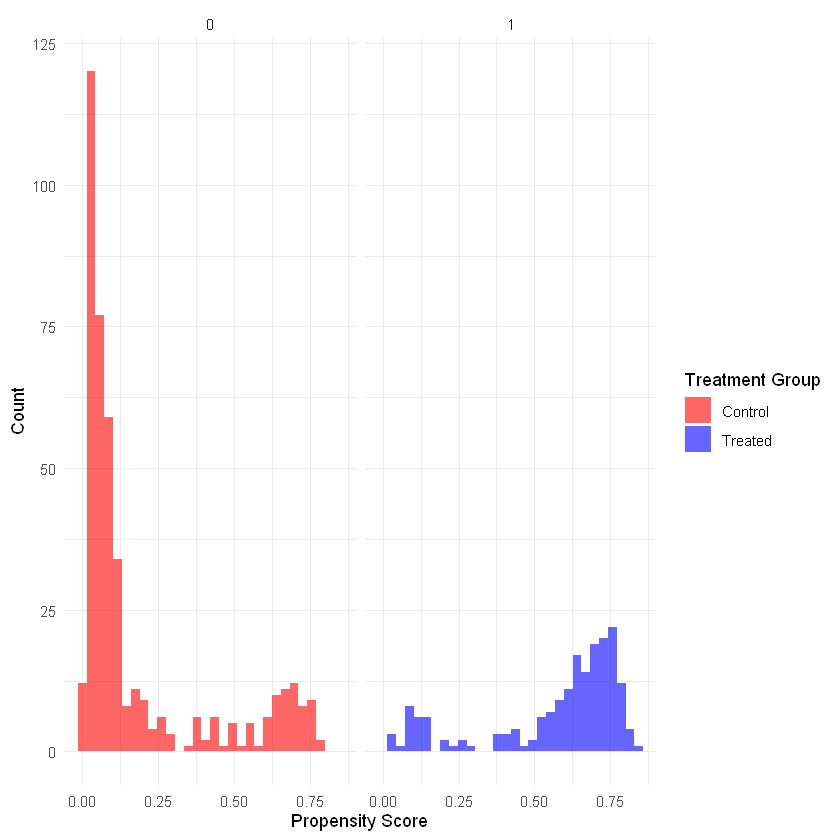

In [ ]:
# Visualizing common support region
library(ggplot2)

propensity_dataframe %>%
  ggplot(aes(x = propensity_score, fill = as.factor(treat))) + 
  geom_histogram(position = "identity", alpha = 0.6, bins = 30) + 
  facet_wrap(~ treat) +
  xlab("Propensity Score") +
  ylab("Count") +
  scale_fill_manual(values = c("0" = "red", "1" = "blue"),
                    name = "Treatment Group",
                    labels = c("Control", "Treated")) +
  theme_minimal()

In [ ]:
# Matching
matching <- matchit(treat ~ re74 + re75 + age + educ +
                      black + hispan + married + nodegree,
                    data = dataset,
                    method = "nearest",
                    replace = TRUE,
                    discard = "both")
summary(matching)


Call:
matchit(formula = treat ~ re74 + re75 + age + educ + black + 
    hispan + married + nodegree, data = dataset, method = "nearest", 
    discard = "both", replace = TRUE)

Summary of Balance for All Data:
         Means Treated Means Control Std. Mean Diff. Var. Ratio eCDF Mean
distance        0.5774        0.1822          1.7941     0.9211    0.3774
re74         2095.5737     5619.2365         -0.7211     0.5181    0.2248
re75         1532.0553     2466.4844         -0.2903     0.9563    0.1342
age            25.8162       28.0303         -0.3094     0.4400    0.0813
educ           10.3459       10.2354          0.0550     0.4959    0.0347
black           0.8432        0.2028          1.7615          .    0.6404
hispan          0.0595        0.1422         -0.3498          .    0.0827
married         0.1892        0.5128         -0.8263          .    0.3236
nodegree        0.7081        0.5967          0.2450          .    0.1114
         eCDF Max
distance   0.6444
re74       0.

In [ ]:

# Create dataframe with just matched data
matched_data <- match.data(matching)

# Calcuate the averages of the confounders (matched dataset)
matched_data %>%
  group_by(treat) %>%
  select(one_of(confounders)) %>%
  summarise_all(list(~ mean(., na.rm = TRUE)))

Adding missing grouping variables: `treat`


treat,re74,re75,age,educ,black,hispan,married,nodegree
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,2209.217,1588.038,24.89024,10.34146,0.6951220,0.12195122,0.2073171,0.6463415
1,2179.390,1485.918,25.44633,10.32203,0.8361582,0.06214689,0.1977401,0.6949153


In [ ]:
# t test the continuous confounders (matched dataset)
lapply(continuous_confounders, function(variable){
  t.test(matched_data[, variable] ~ matched_data[, 'treat'])})


[[1]]

	Welch Two Sample t-test

data:  matched_data[, variable] by matched_data[, "treat"]
t = 0.048816, df = 177.91, p-value = 0.9611
alternative hypothesis: true difference in means between group 0 and group 1 is not equal to 0
95 percent confidence interval:
 -1175.906  1235.559
sample estimates:
mean in group 0 mean in group 1 
       2209.217        2179.390 


[[2]]

	Welch Two Sample t-test

data:  matched_data[, variable] by matched_data[, "treat"]
t = 0.27087, df = 190.76, p-value = 0.7868
alternative hypothesis: true difference in means between group 0 and group 1 is not equal to 0
95 percent confidence interval:
 -641.5332  845.7736
sample estimates:
mean in group 0 mean in group 1 
       1588.038        1485.918 


[[3]]

	Welch Two Sample t-test

data:  matched_data[, variable] by matched_data[, "treat"]
t = -0.44357, df = 116.79, p-value = 0.6582
alternative hypothesis: true difference in means between group 0 and group 1 is not equal to 0
95 percent confidence interval

In [ ]:
# Evaluate the impact of the training (income of 78)
impact_training <- lm(re78 ~ treat + re74 + re75 + age + educ +
                        black + hispan + married + nodegree, 
                      data = matched_data)
summary(impact_training)


Call:
lm(formula = re78 ~ treat + re74 + re75 + age + educ + black + 
    hispan + married + nodegree, data = matched_data)

Residuals:
   Min     1Q Median     3Q    Max 
 -8917  -4868  -1772   3497  27349 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)  
(Intercept) -1.494e+02  3.926e+03  -0.038   0.9697  
treat        1.513e+03  8.659e+02   1.747   0.0819 .
re74         6.373e-02  1.134e-01   0.562   0.5747  
re75         1.751e-01  1.799e-01   0.973   0.3314  
age          2.620e+01  5.384e+01   0.487   0.6269  
educ         4.387e+02  2.469e+02   1.777   0.0768 .
black       -1.023e+03  1.234e+03  -0.829   0.4078  
hispan      -4.168e+02  1.827e+03  -0.228   0.8197  
married      3.959e+02  1.101e+03   0.360   0.7194  
nodegree    -1.038e+02  1.212e+03  -0.086   0.9318  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 6377 on 249 degrees of freedom
Multiple R-squared:  0.06263,	Adjusted R-squared:  0.02875 
F-statist

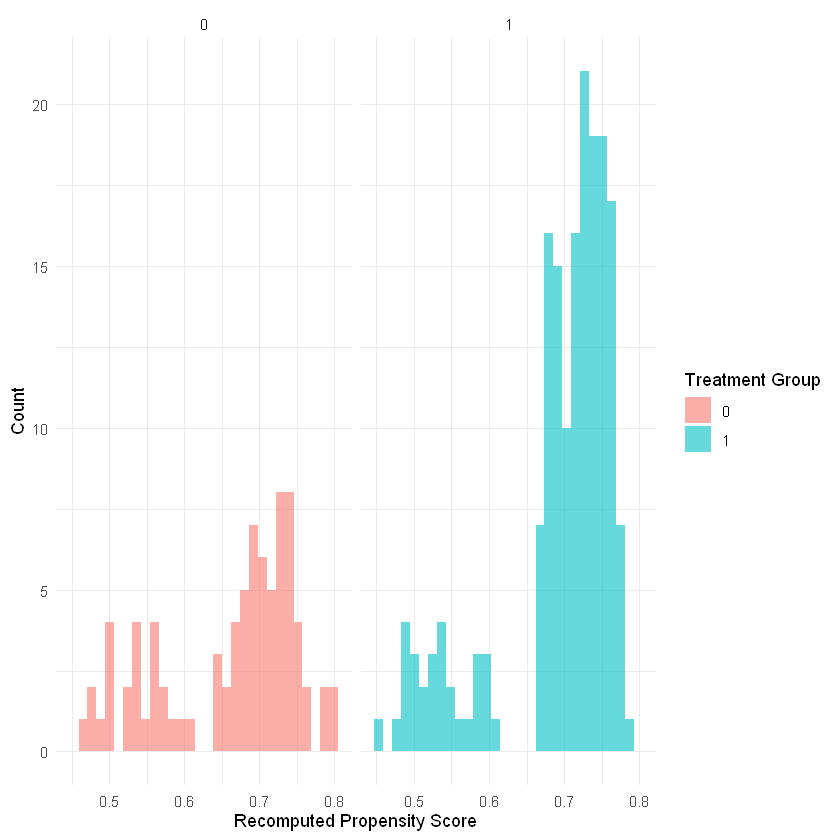

In [ ]:
# a). Re-fit propensity model on matched data
recomputed_model <- glm(treat ~ re74 + re75 + age + educ +
                          black + hispan + married + nodegree,
                        family = "binomial",
                        data = matched_data)

# b). Recalculate propensity scores for matched data
matched_data$recomputed_pscore <- predict(recomputed_model, type = "response")

# c). Create new dataframe for common support visualization
recomputed_propensity_df <- matched_data %>%
  select(treat, recomputed_pscore)

# d). Visualize the common support region
ggplot(recomputed_propensity_df, aes(x = recomputed_pscore, fill = as.factor(treat))) +
  geom_histogram(position = "identity", alpha = 0.6, bins = 30) +
  facet_wrap(~ treat) +
  xlab("Recomputed Propensity Score") +
  ylab("Count") +
  labs(fill = "Treatment Group") +
  theme_minimal()

### Summary
In randomized experiments, treatment assignment occurs randomly. However, in observational studies, this is not the case. Propensity Score Matching (PSM) is employed to approximate randomization by balancing covariates between treated and control groups, thereby mitigating selection bias.

In this project, we estimated propensity scores using logistic regression and implemented nearest-neighbor matching to pair treated and untreated individuals with similar characteristics. We assessed covariate balance using t-tests and further validated the quality of matching by recomputing propensity scores on the matched dataset and visualizing the common support region to ensure sufficient overlap between groups.

This project acknowledges resources from Udemy and The Elements of Statistical Learning.